# Convolutional Neural Networks

## Practical 2

_**Building an Image Classifier using a Pretrained Xception Model on TensorFlow Flower Dataset.**_

NOTE: This notebook is recommended to run on GPU to save time during model training.

In [1]:
# Imports required packages

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds    # THIS MIGHT NEED TO BE INSTALLED SEPERATELY
import matplotlib.pyplot as plt

In [2]:
# Loads the TensorFlow Flowers dataset
# NOTE: Downloading for the first time may take few minutes to complete

tf_flowers, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
# Extract useful information about the dataset

dataset_size = info.splits["train"].num_examples    # Number of instances
class_names = info.features["label"].names          # Name of the flowers
n_classes = info.features["label"].num_classes      # Count of types of flowers

In [4]:
# Prints the size of the dataset
print(dataset_size)

3670


In [5]:
# Prints the types of flower the dataset has images of
print(class_names)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [6]:
# Prints the count of flower types
print(n_classes)

5


In [7]:
# As this dataset does not provide a seperate test dataset, training set gets further splitted
# into test [first 10%], validation [next 15%] and train [remaining 75%] dataset.

test_set_raw, val_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

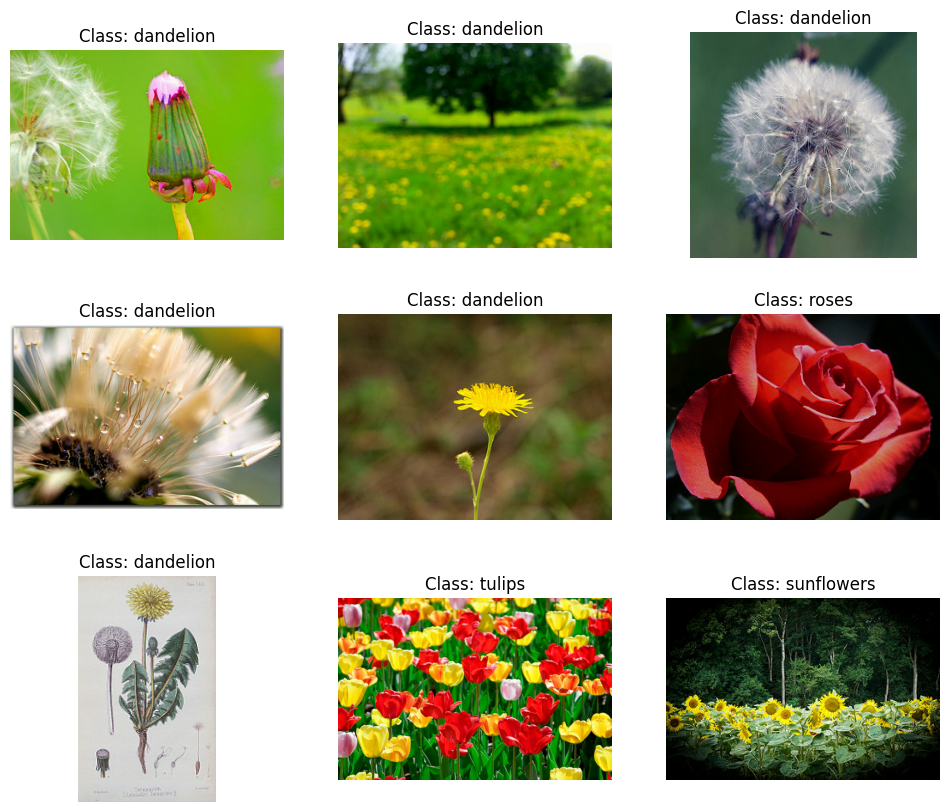

In [8]:
# Plots any 9 flowers to check how they look

plt.figure(figsize=(12, 10))
index = 0
for image, label in val_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

As training instances required to be of the same size during batch processing, image resizing is done over a _Resizing_ layer. Function **tf.keras.applications.xception.preprocess_input()** also needs to be called to preprocess the images appropriately for the _Xception_ model. Shuffling and prefetching are also added to the training dataset.

In [9]:
tf.random.set_seed(42)

batch_size = 32

# Configures a preprocessing layer for image resizing
preprocess = tf.keras.Sequential([
    # To resize each image
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),

    # to preprocess the resized image appropriately for the Xception model
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

# Image instances in different datasets get passed through the preprocessing layer to get resized.

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))

train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)  # Note that only train dataset gets additional
                                                                            # shuffling for effective batch processing

val_set = val_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Now each batch contains 32 images, all of them 224 × 224 pixels, with pixel values ranging from –1 to 1.

Loads the pretrained model, without its top layers, and then replace them with the ones specific to this flower classification task.

In [11]:
# NOTE THAT DOWNLOADING XCEPTION WEIGHTS (PRETRAINED ON IMAGENET) MAY TAKE SEVERAL MINUTES TO COMPLETE

tf.random.set_seed(42)

# Loads Xception pretrained model without top layers [i.e. global average pooling and dense output layer]
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

# Adds an global average pooling layer at the output of the base model that
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Adds a dense output layer
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

# Assembles the model with layers created in the above steps
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


**Trains the model for a few epochs, while keeping the base model weights fixed.**

In [12]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# NOTE THAT FOLLOWING MODEL TRAINING MAY TAKE SEVERAL MINUTES TO COMPLETE IF RUN ON CPU
history = model.fit(train_set, validation_data=val_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.7019 - loss: 1.0273 - val_accuracy: 0.8512 - val_loss: 0.7049
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.9060 - loss: 0.3747 - val_accuracy: 0.8330 - val_loss: 0.8588
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9331 - loss: 0.2144 - val_accuracy: 0.8294 - val_loss: 0.8350


Weights of our new top layers do not seem to be too bad, so, top part of the base model can be made trainable again, and training can be continued, but with a lower learning rate.

In [14]:
# [OPTIONAL], Additionally, the above model with non-trainable Xception weights can be saved for later references.
# NOTE: Make sure the folder "models" exists under the current working directory

model.save("./models/my_tf-flowers_model_on_non-trainable_xception_weights.keras")

In [15]:
# Lists base model's layers

for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_1          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

**Now, unfreezes some of the base model’s top layers [layers 56 and above i.e. the start of residual unit 7 out of 14], and then continue training with reduced learning rate.**

In [16]:
for layer in base_model.layers[56:]:
    layer.trainable = True

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_set, validation_data=val_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.8640 - loss: 0.4353 - val_accuracy: 0.8566 - val_loss: 0.6345
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - accuracy: 0.9834 - loss: 0.0580 - val_accuracy: 0.8947 - val_loss: 0.3770
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - accuracy: 0.9922 - loss: 0.0277 - val_accuracy: 0.8984 - val_loss: 0.3350
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - accuracy: 0.9926 - loss: 0.0237 - val_accuracy: 0.9093 - val_loss: 0.3270
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - accuracy: 0.9964 - loss: 0.0097 - val_accuracy: 0.9056 - val_loss: 0.3412
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - accuracy: 0.9974 - loss: 0.0103 - val_accuracy: 0.9111 - val_loss: 0.3457
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.9966 - loss: 0.0071 - val_accuracy: 0.9111 - val_loss: 0.3725
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - accuracy: 0.9975 - loss: 0.0078 - val_accu

In [18]:
# After the model training the validation accuracy was observed to be 90.56%.
# Now, model's performance on test dataset is evaluted below.
model.evaluate(test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 597ms/step - accuracy: 0.9429 - loss: 0.2567


[0.2495919018983841, 0.9455040693283081]

The above evaluation shows that the trained model's accuracy is 94.55%.